In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Grafik çizimi ve matematiksel işlemler için
import matplotlib.pyplot as plt
import numpy as np
import os # İşletim sistemiyle ilgili (dosya yolu) işlemler için

# Google Drive'ı Colab'a bağlama
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1. Veri Setimizin Google Drive'daki Yolu
# ÖNEMLİ: Eğer Drive'ınız Türkçe ise "My Drive" yerine "Drive'ım" yazmanız gerekebilir.
# Lütfen Colab'ın solundaki "Dosyalar" (File) sekmesinden bu yolu kontrol edin.
# Genellikle /content/drive/My Drive/Colab Notebooks/MasaObjeleri/dataset şeklindedir
# VEYA /content/drive/MyDrive/Colab Notebooks/MasaObjeleri/dataset

# Lütfen aşağıdaki yolu kendi Drive yapınıza göre GÜNCELLEYİN:
# Sol taraftaki dosya gezgininden dataset klasörüne sağ tıklayıp "Yolu kopyala" diyebilirsiniz.
base_dir = '/content/drive/MyDrive/Colab Notebooks/MasaObjeleri/dataset'

# 2. Proje Föyünün İstediği ve Bizim Karar Verdiğimiz Parametreler
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32 # Verileri eğitime 32'şerli gruplar halinde vereceğiz
EPOCHS = 15     # Modelin veri seti üzerinden 15 kez geçerek öğrenmesi

In [4]:
# 1. ImageDataGenerator'u oluştur ve ayarla
# rescale=1./255 -> Piksel değerlerini 0-1 arasına normalize et
# validation_split=0.2 -> Verinin %20'sini test/doğrulama için ayır
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Verinin %20'si doğrulama için ayrılacak
)

# 2. Eğitim (Training) verilerini yükle
# "subset='training'" -> %80'lik kısmı al
train_generator = datagen.flow_from_directory(
    base_dir,  # Adım 7'de belirlediğimiz ana klasör yolu
    target_size=IMAGE_SIZE,  # Resimleri 128x128 yap
    batch_size=BATCH_SIZE,
    class_mode='binary',  # İki sınıfımız var (mouse, havya) -> 'binary'
    subset='training'
)

# 3. Doğrulama (Validation) verilerini yükle
# "subset='validation'" -> %20'lik kısmı al
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 86 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [5]:
# 1. ImageNet ile eğitilmiş VGG16 modelini temel olarak yükle
# include_top=False -> Bizim sınıflandırma katmanımızı ekleyeceğimiz için
# input_shape -> Bizim resim boyutumuzu (128x128, 3 renk kanalı) belirtir
base_model = tf.keras.applications.VGG16(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Temel modelin katmanlarını dondur (yeniden eğitilmesin)
base_model.trainable = False

# 3. Kendi modelimizi oluşturalım (Sequential API)
model1 = Sequential([
    base_model,  # VGG16'nın dondurulmuş halini ekle
    layers.Flatten(),  # VGG16'dan gelen çok boyutlu sonucu düzleştir

    # Kendi sınıflandırıcımız (Burası eğitilecek)
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Aşırı öğrenmeyi (overfitting) engellemek için
    layers.Dense(1, activation='sigmoid') # İkili sınıflandırma (binary) için 'sigmoid'
                                        # 1 -> (mouse veya havya)
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Modeli derleme (ayarlarını yapılandırma)

model1.compile(
    optimizer='adam',  # Popüler ve genellikle iyi çalışan bir optimizasyon algoritması
    loss='binary_crossentropy', # İkili sınıflandırma (0 veya 1) için standart kayıp fonksiyonu
    metrics=['accuracy'] # Eğitim sırasında doğruluk oranını takip et
)

# Modelin mimarisini (katmanlarını) özetle
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# Modeli eğitmeye başla!

# model1.fit -> modeli eğit
# train_generator -> Adım 8'de oluşturduğumuz 86 resimlik eğitim verisi
# epochs=EPOCHS -> Adım 7'de 15 olarak belirlediğimiz "tur" sayısı
# validation_data=validation_generator -> Adım 8'deki 20 resimlik doğrulama verisi
# validation_steps -> Doğrulama verisi boyutu / BATCH_SIZE

history = model1.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 16s/step - accuracy: 0.5729 - loss: 1.0820 - val_accuracy: 1.0000 - val_loss: 0.3228
Epoch 2/15
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.7727 - loss: 0.4334

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.7727 - loss: 0.4334 - val_accuracy: 0.5500 - val_loss: 0.8239
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 12s/step - accuracy: 0.7500 - loss: 0.6037 - val_accuracy: 0.6000 - val_loss: 0.4077
Epoch 4/15
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8182 - loss: 0.3547

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.8182 - loss: 0.3547 - val_accuracy: 1.0000 - val_loss: 0.1556
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 12s/step - accuracy: 0.9479 - loss: 0.1747 - val_accuracy: 0.8500 - val_loss: 0.1910
Epoch 6/15
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.9545 - loss: 0.1072

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9545 - loss: 0.1072 - val_accuracy: 0.8500 - val_loss: 0.1997
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.9649 - loss: 0.1489 - val_accuracy: 0.9500 - val_loss: 0.1168
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9062 - loss: 0.2412 - val_accuracy: 1.0000 - val_loss: 0.0645
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.9792 - loss: 0.0757 - val_accuracy: 1.0000 - val_loss: 0.0755
Epoch 10/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.9545 - loss: 0.0576 - val_accuracy: 1.0000 - val_loss: 0.1153
Epoch 11/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 12s/step - accuracy: 0.9877 - loss: 0.0458 - val_accuracy: 0.9000 - val_loss: 0.1801
Epoch 12/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.9375 - loss: 0.1092 - val_accuracy: 0.9000 - val_loss: 0.1594
Epoch 13/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 12s/step - accuracy: 0.9896 - loss: 0.0368 - val_accuracy: 0.9500 - val_loss: 0.1006
Epoch 14/15
2

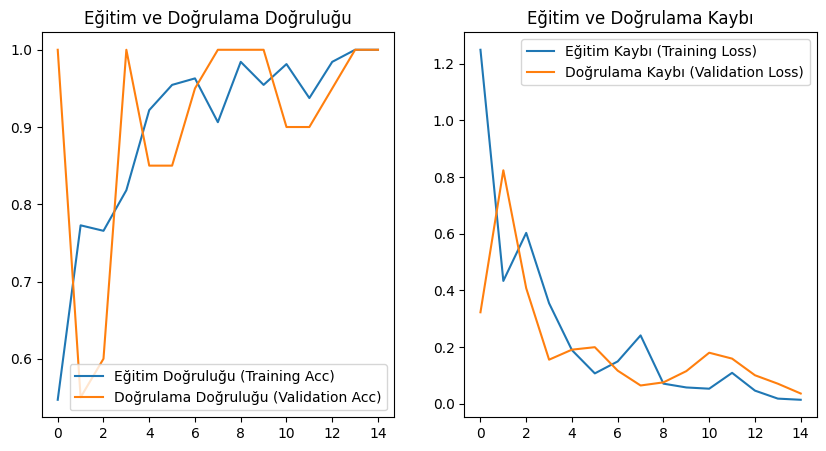


--- Model 1 Raporu ---
Model 1'in son (Test/Doğrulama) doğruluğu: %100.00


In [9]:
# Eğitim sonuçlarını (history) al
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS) # 15 epoch'luk Eksen

# 1. Grafik: Eğitim ve Doğrulama DOĞRULUK Grafiği
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu (Training Acc)')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu (Validation Acc)')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')

# 2. Grafik: Eğitim ve Doğrulama KAYIP Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Training Loss)')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation Loss)')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

# Test (Doğrulama) Seti Sonucunu Raporla
print("\n--- Model 1 Raporu ---")
final_val_accuracy = val_acc[-1] # Listenin son elemanı, son epoch'taki doğruluktur
print(f"Model 1'in son (Test/Doğrulama) doğruluğu: %{final_val_accuracy * 100:.2f}")